# This notebook will show how to use the ROSE framework to run two active learn algorthims in parallel and select the best one based on a metric.

In [1]:
import os
import sys

from rose.learner import AlgorithmSelector
from rose.engine import Task, ResourceEngine
from rose.metrics import MEAN_SQUARED_ERROR_MSE

Lets prepare our execution engine on a local resource (user computer). We will ask for 30 minutes as this example will run fast.

In [2]:
engine = ResourceEngine({'runtime': 30,
                         'resource': 'local.localhost'})
algo_selector = AlgorithmSelector(engine)
code_path = f'{sys.executable} {os.getcwd()}'

Resource Engine started successfully

Task 'simulation' ready to submit; resolved dependencies: []
Task 'simulation' ready to submit; resolved dependencies: []
submitting ['simulation', 'simulation'] for execution
task.000000 is DONE
task.000002 is DONE
Task 'training' ready to submit; resolved dependencies: ['simulation']
Task 'training' ready to submit; resolved dependencies: ['simulation']
submitting ['training', 'training'] for execution
task.000004 is DONE
Task 'active_learn_2' ready to submit; resolved dependencies: ['simulation', 'training']
submitting ['active_learn_2'] for execution
task.000001 is DONE
Task 'active_learn_1' ready to submit; resolved dependencies: ['simulation', 'training']
submitting ['active_learn_1'] for execution
task.000006 is DONE
Task 'check_mse' ready to submit; resolved dependencies: ['active_learn_2']
submitting ['check_mse'] for execution
task.000003 is DONE
Task 'check_mse' ready to submit; resolved dependencies: ['active_learn_1']
submitting ['chec

Similar to our previous tutorials, we will define our active learn workflow components. Please note that, unlike the previous turorails, we defined **two** active learn task (`algo1` and `algo2`). ROSE will select which one is the best based on the number of iterations and the final selected metric.

In [3]:
# Define and register the simulation task
@algo_selector.simulation_task
def simulation(*args):
    return Task(executable=f'{code_path}/sim.py')

# Define and register the training task
@algo_selector.training_task
def training(*args):
    return Task(executable=f'{code_path}/train.py')

# Define and register Multiple AL tasks
@algo_selector.active_learn_task(name='algo_1')
def active_learn_1(*args):
    return Task(executable=f'{code_path}/active_1.py')

@algo_selector.active_learn_task(name='algo_2')
def active_learn_2(*args):
    return Task(executable=f'{code_path}/active_2.py')

# Defining the stop criterion with a metric (MSE in this case)
@algo_selector.as_stop_criterion(metric_name=MEAN_SQUARED_ERROR_MSE, threshold=0.01)
def check_mse(*args):
    return Task(executable=f'{code_path}/check_mse.py')

Now, lets invoke our workflow and instruct rose to select one of both algorithms.

In [4]:
# Now, call the tasks and teach
simul = simulation()
train = training()
active_1 = active_learn_1()
active_2 = active_learn_2()
stop_cond = check_mse()

# Start the teaching process
algo_selector.teach_and_select(max_iter=4)
engine.shutdown()

Pipeline-algo_1 is submitted for execution
Registered task 'simulation' and id of 000000 with dependencies: []
Pipeline-algo_2 is submitted for execution
Registered task 'training' and id of 000001 with dependencies: ['simulation']
[Pipeline: active_learn_1] Starting Iteration-0
Registered task 'simulation' and id of 000002 with dependencies: []
Registered task 'active_learn_1' and id of 000003 with dependencies: ['simulation', 'training']
Registered task 'training' and id of 000004 with dependencies: ['simulation']
[Pipeline: active_learn_2] Starting Iteration-0
Registered task 'check_mse' and id of 000005 with dependencies: ['active_learn_1']
Registered task 'active_learn_2' and id of 000006 with dependencies: ['simulation', 'training']
Registered task 'check_mse' and id of 000007 with dependencies: ['active_learn_2']
stop criterion metric: mean_squared_error_mse is not met yet (0.030472507087414315).
Registered task 'simulation' and id of 000008 with dependencies: ['active_learn_2']

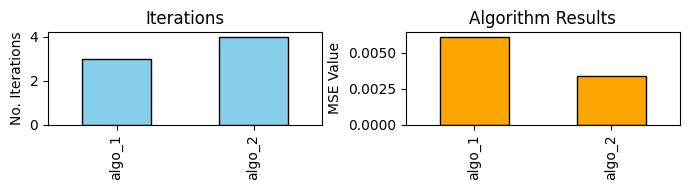

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
results = {
    'algo_1': {'iterations': 3, 'last_result': 0.0061},
    'algo_2': {'iterations': 4, 'last_result': 0.0034}
}

# Convert to DataFrame
df = pd.DataFrame(results).T  # Transpose to have algorithms as index

# Create a figure with two subplots: one for iterations and one for last_result
fig, ax = plt.subplots(1, 2, figsize=(7, 2))

# Plot iterations
df['iterations'].plot(kind='bar', ax=ax[0], color='skyblue', title='Iterations', edgecolor='black')
ax[0].set_ylabel('No. Iterations')

# Plot last_result
df['last_result'].plot(kind='bar', ax=ax[1], color='orange', title='Algorithm Results', edgecolor='black')
ax[1].set_ylabel('MSE Value')

# Show plot
plt.tight_layout()
plt.show()